# Test 3 SOM on Kepler and TESS Data

The third test done on the dataset combined with the Kepler and TESS data processed with the Min Max technique. Using the dataset without under-sampling, but eliminating some anomalous characteristics and initializing the SOM weights with 50% composed of Planet values taken randomly, and 50% False Planets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

from sklearn.model_selection import train_test_split
from simple_som.som_grid_search import SOMGridSearch
from simple_som.som import SimpleSOM
from simple_som.visualization import View
from utils.color import Color
from utils.util import print_count_nan, plot_confusion_matrix
from utils.ditance_metrics import DistanceMetrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
X_train = pd.read_csv('../data/processed_data/X_kepler_tess.csv')
y_train = pd.read_csv('../data/processed_data/y_kepler_tess.csv')
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print_count_nan(data=X_train, name='X_train')
print_count_nan(data=y_train, name='y_train')
print('X Col', X_train.columns)
print('y Col', y_train.columns)

Shape of X_train: (13798, 18)
Shape of y_train: (13798, 2)
Number of not a numbers values in X_train: 0 out of 248364: 0.00%
Number of not a numbers values in y_train: 0 out of 27596: 0.00%
X Col Index(['Unnamed: 0', 'Period (days)', 'Period (days) err', 'Duration (hours)',
       'Duration (hours) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth) err', 'Planet Radius (R_Earth)',
       'Planet Equil Temp (K)', 'Planet Insolation (Earth Flux)', 'Planet SNR',
       'Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
       'Stellar log(g) (cm/s^2)', 'Stellar Mass (M_Sun)',
       'Stellar Mass (M_Sun) err', 'TESS Mag'],
      dtype='object')
y Col Index(['Unnamed: 0', '0'], dtype='object')


In [3]:
X_train = X_train.drop(columns=['Unnamed: 0','Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
                                'Stellar log(g) (cm/s^2)', 'TESS Mag'])

In [4]:
print('X Col', X_train.columns)
print('y Col', y_train.columns)

X Col Index(['Period (days)', 'Period (days) err', 'Duration (hours)',
       'Duration (hours) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth) err', 'Planet Radius (R_Earth)',
       'Planet Equil Temp (K)', 'Planet Insolation (Earth Flux)', 'Planet SNR',
       'Stellar Mass (M_Sun)', 'Stellar Mass (M_Sun) err'],
      dtype='object')
y Col Index(['Unnamed: 0', '0'], dtype='object')


In [5]:
component_names = ['Period (days)', 'Period (days) err', 'Duration (hours)',
       'Duration (hours) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth) err', 'Planet Radius (R_Earth)',
       'Planet Equil Temp (K)', 'Planet Insolation (Earth Flux)', 'Planet SNR',
       'Stellar Mass (M_Sun)', 'Stellar Mass (M_Sun) err']

In [6]:
X_train = X_train.values
y_train = y_train.drop(columns='Unnamed: 0').values

In [7]:
TESTSET_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=TESTSET_SIZE, 
                                                    random_state=RANDOM_STATE, shuffle=True,
                                                    stratify=None)
print("Number of X_train: ", X_train.shape[0])
print("Number of X_test: ", X_test.shape[0])
print("Number of features: ", X_train.shape[1])

Number of X_train:  11038
Number of X_test:  2760
Number of features:  13


# Grid Search

In [8]:
param_grid = {
    'W': [None],
    'max_iter': [14000],
    'num_rows': [20],
    'num_cols': [20],
    'max_learning_rate': [0.8],
    'max_distance': [6, 10],
    'distance_bmu': [DistanceMetrics.euclidean_distance, DistanceMetrics.manhattan_distance],
    'distance_nr': [DistanceMetrics.euclidean_distance, DistanceMetrics.manhattan_distance],
    'W_PLANET': [0.9, 1],
    'W_FALSE_PLANET': [1, 1.1],
    'K': [3, 5, 7, 11]
}

In [9]:
# grid_search = SOMGridSearch(param_grid=param_grid, n_jobs=-1)
# best_param, best_score = grid_search.fit(X_train, y_train, X_test, y_test)

# print("Best param:", best_param)
# print("Best accuracy:", best_score)
#################################################################################
# Best param: {'W': None, 'max_iter': 14000, 'num_rows': 20, 'num_cols': 20,
# 'max_learning_rate': 0.8, 'max_distance': 10,
# 'distance_bmu': <function DistanceMetrics.manhattan_distance at 0x2b3852fc0700>,
# 'distance_nr': <function DistanceMetrics.manhattan_distance at 0x2b3852fc0700>,
# 'W_PLANET': 0.9, 'W_FALSE_PLANET': 1, 'K': 7}
# Best accuracy: 0.775

In [9]:
best_param = {}
best_param['W'] = None
best_param['max_iter'] = 14000
best_param['num_rows'] = 30
best_param['num_cols'] = 30
best_param['max_learning_rate'] = 0.8
best_param['max_distance'] = 10
best_param['distance_bmu'] = DistanceMetrics.manhattan_distance
best_param['distance_nr'] = DistanceMetrics.manhattan_distance
best_param['W_PLANET'] = 0.9
best_param['W_FALSE_PLANET'] = 1
best_param['K'] = 7

In [10]:
W = best_param['W']
max_iter = best_param['max_iter']
num_rows = best_param['num_rows']
num_cols = best_param['num_cols']
max_learning_rate = best_param['max_learning_rate']
max_distance = best_param['max_distance']
distance_bmu = best_param['distance_bmu']
distance_nr = best_param['distance_nr']
w_planet = best_param['W_PLANET']
w_false_planet = best_param['W_FALSE_PLANET']
K = best_param['K']

In [11]:
som = SimpleSOM(X_train=X_train, y_train=y_train, W=None, max_iter=max_iter, 
                num_rows=num_rows, num_cols=num_cols, max_learning_rate=max_learning_rate,
                max_distance=max_distance, distance_bmu=distance_bmu, distance_nr=distance_nr, 
                W_PLANET=w_planet, W_FALSE_PLANET=w_false_planet, K=K, n_jobs=-1)
params = som.fit(X_data=X_train, verbose=2)

Iteration:  00001  | QE:    0.000003  | LR:    0.800000  | NR:   10.000000  | Time:    0.011601
Iteration:  01000  | QE:    0.000003  | LR:    0.742914  | NR:   10.000000  | Time:    7.065296
Iteration:  02000  | QE:    0.000005  | LR:    0.685771  | NR:    9.000000  | Time:    7.178068
Iteration:  03000  | QE:    0.000001  | LR:    0.628629  | NR:    8.000000  | Time:    6.875515
Iteration:  04000  | QE:    0.000008  | LR:    0.571486  | NR:    8.000000  | Time:    7.322073
Iteration:  05000  | QE:    0.000002  | LR:    0.514343  | NR:    7.000000  | Time:    7.514000
Iteration:  06000  | QE:    0.000001  | LR:    0.457200  | NR:    6.000000  | Time:    8.238077
Iteration:  07000  | QE:    0.000004  | LR:    0.400057  | NR:    6.000000  | Time:    7.376432
Iteration:  08000  | QE:    0.000004  | LR:    0.342914  | NR:    5.000000  | Time:    7.492542
Iteration:  09000  | QE:    0.000002  | LR:    0.285771  | NR:    4.000000  | Time:    7.128716
Iteration:  10000  | QE:    0.000002  | 

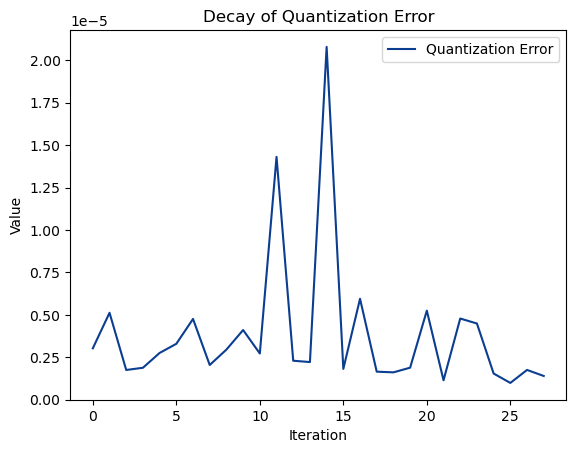

In [12]:
REDUCE = 500
plt.plot(range(max_iter//REDUCE), params['errors'][::REDUCE], 
         label='Quantization Error', color=Color.SEA.value)
plt.title('Decay of Quantization Error')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

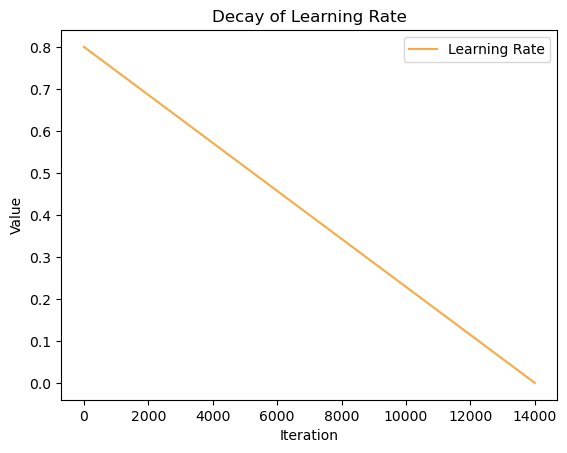

In [14]:
plt.plot(range(max_iter), params['lr'], label='Learning Rate', color=Color.SUN.value)
plt.title('Decay of Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

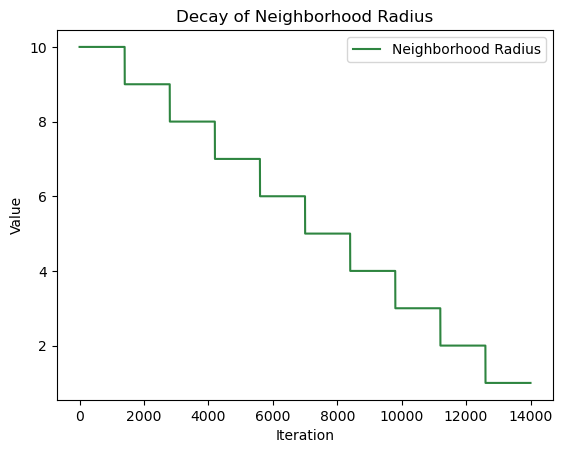

In [15]:
plt.plot(range(max_iter), params['nr'], label='Neighborhood Radius', color=Color.EARTH.value)
plt.title('Decay of Neighborhood Radius')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

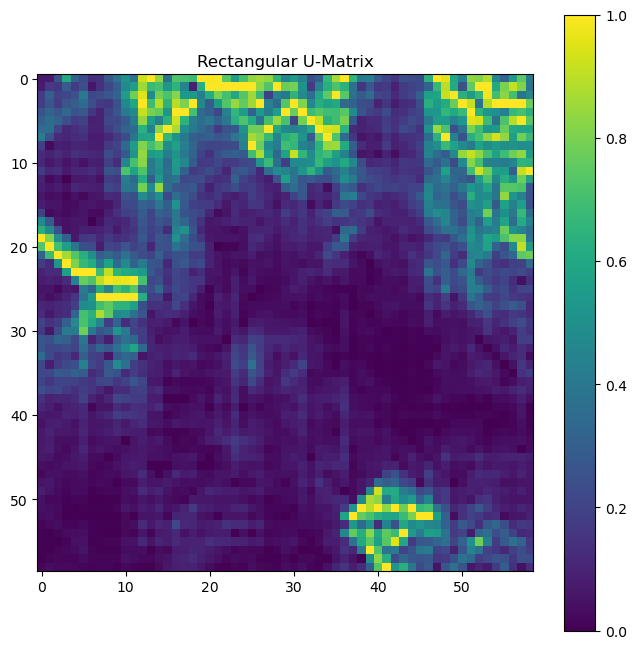

In [13]:
u_matrix_rect = View.make_u_rect(som=som)
plt.figure(figsize=(8, 8))
plt.imshow(u_matrix_rect, cmap='viridis', interpolation='none')
plt.title('Rectangular U-Matrix')
plt.colorbar()
plt.show()

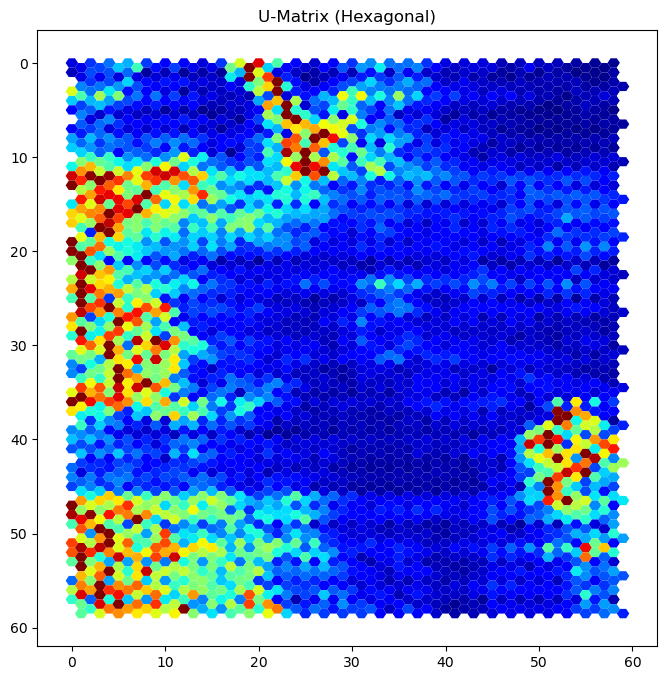

In [14]:
u_matrix_hex = View.make_u_hex(som=som)
fig, ax = plt.subplots(figsize=(8,8))
View.draw_hex_grid(som, ax, u_matrix_hex)
plt.show()

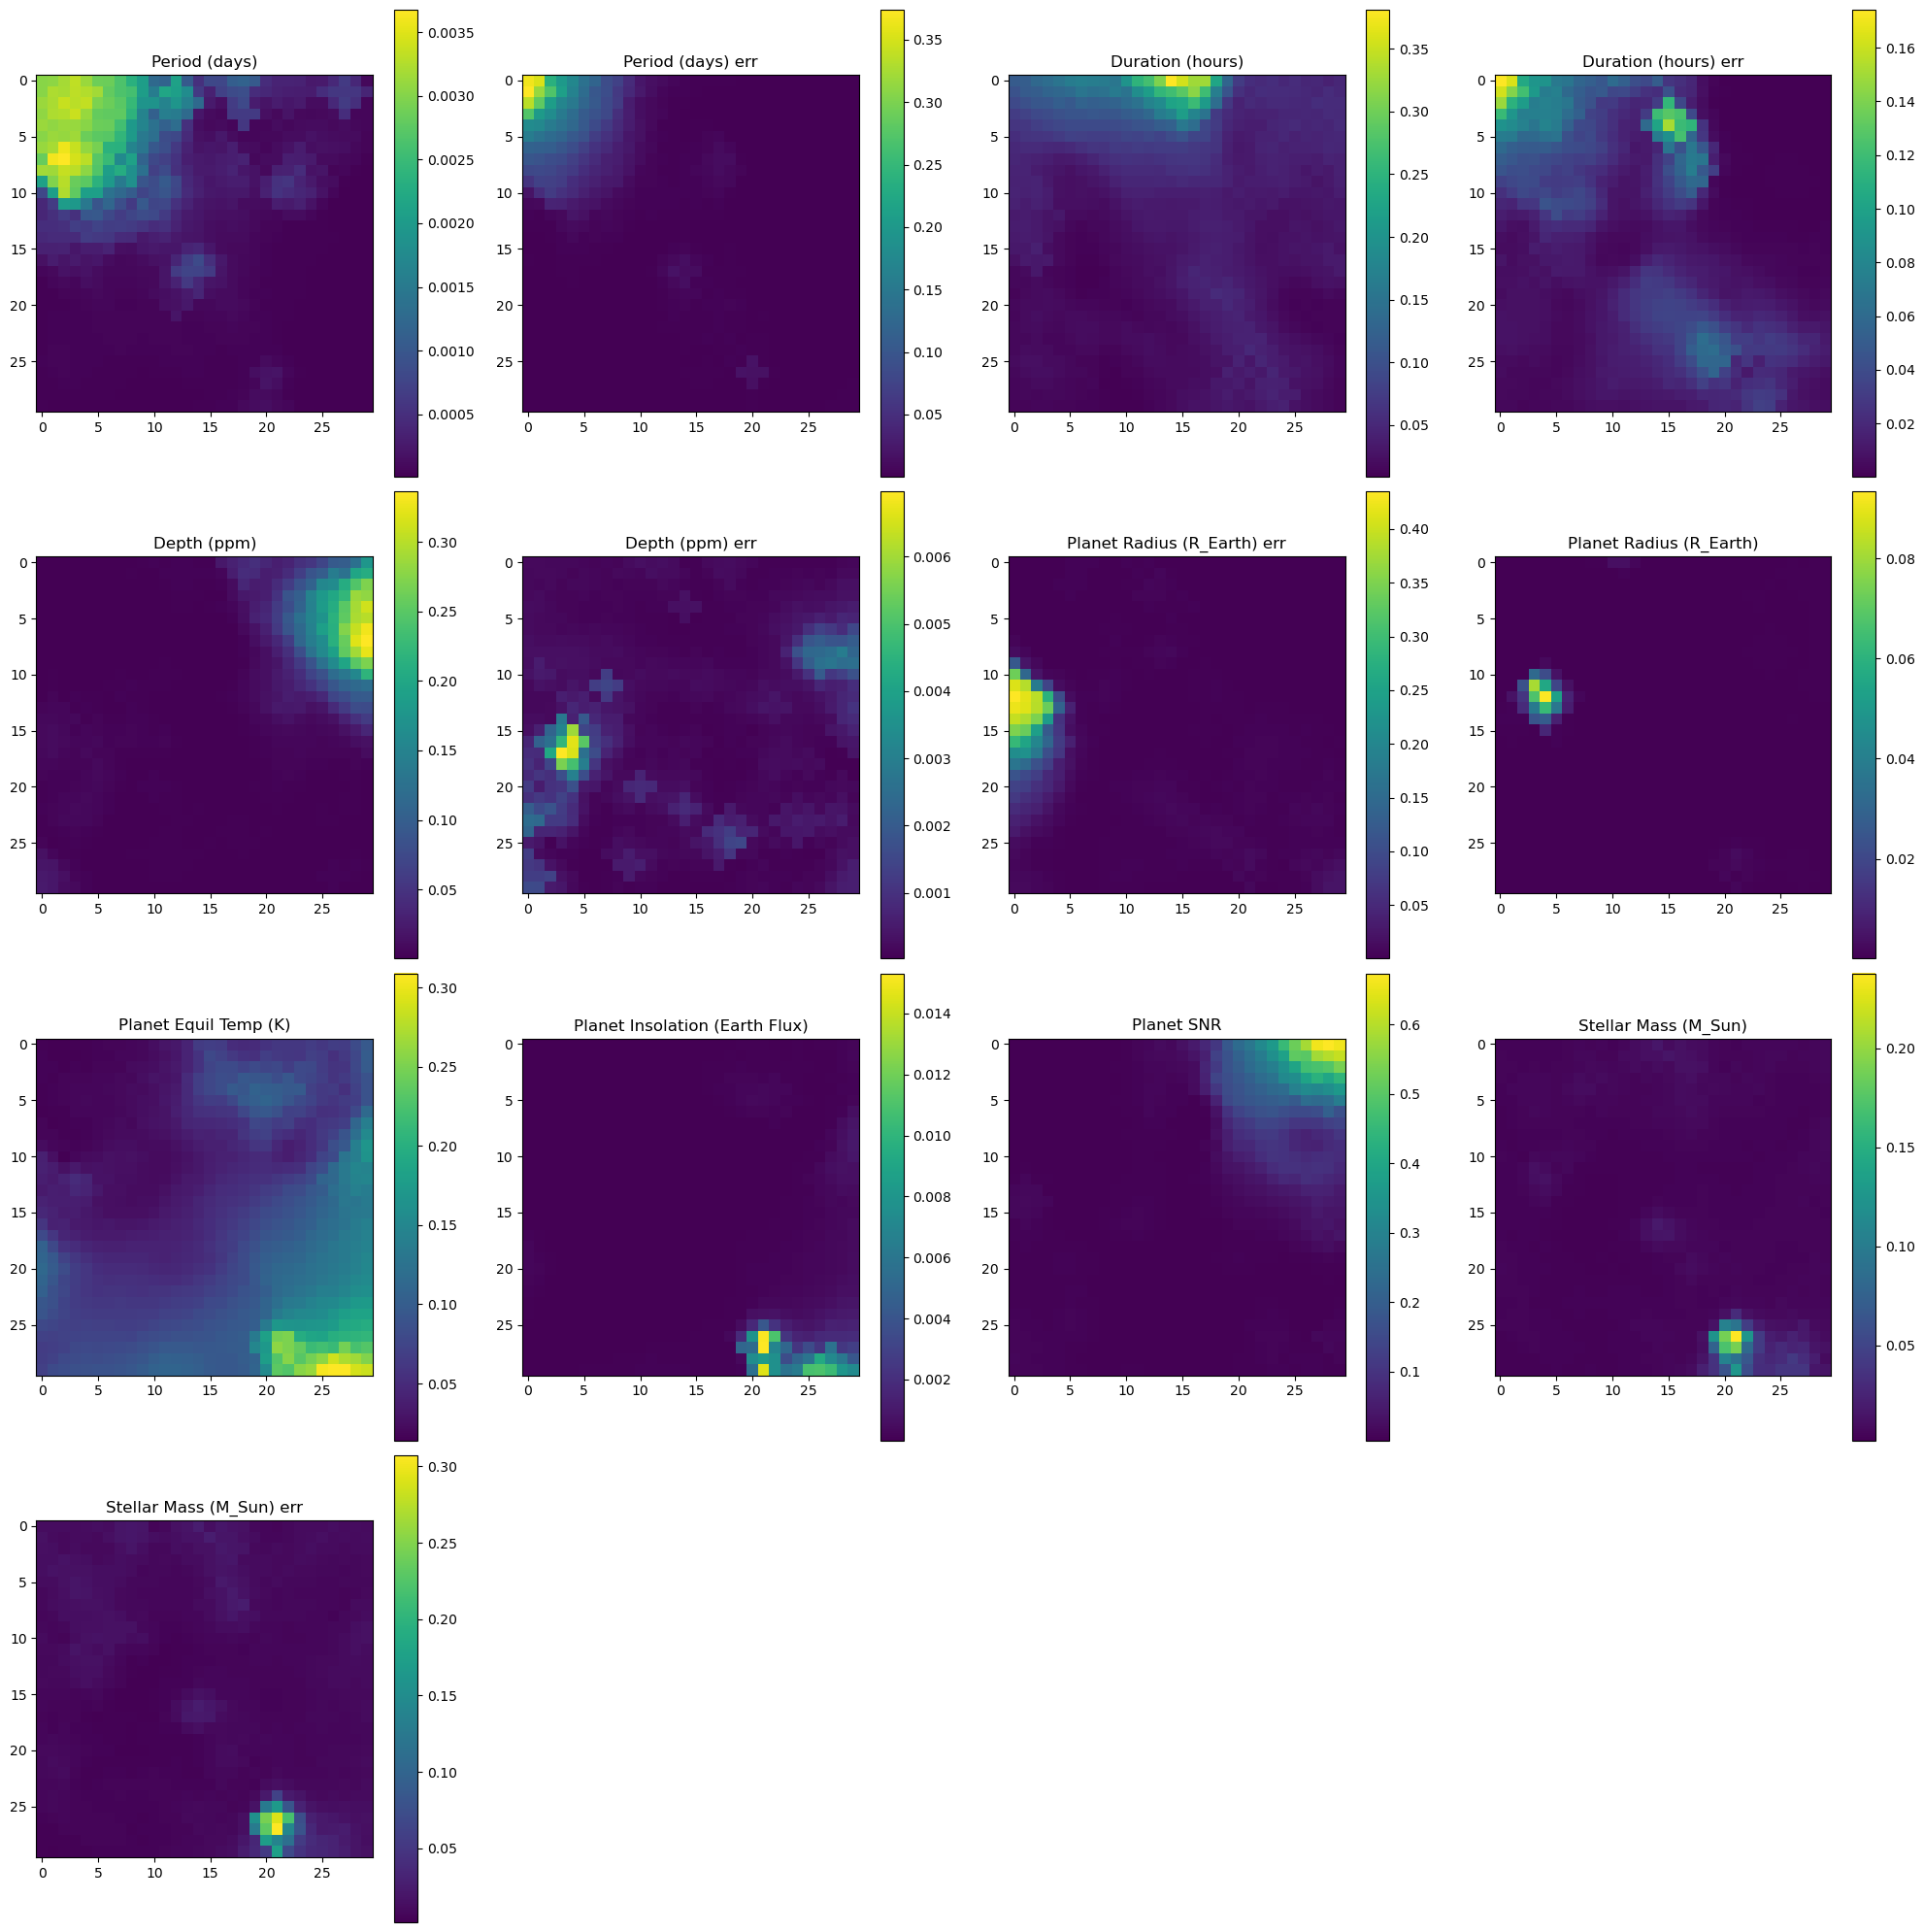

In [15]:
fig = plt.figure(figsize=(20, 20))
View.make_u_slide(component_names=component_names, som=som)
plt.show()

In [17]:
BMUs, BMU_labels = som.calculate_bmu_and_labels()
BMU_label_combinations = list(zip(BMUs, BMU_labels))
BMU_counts = som.bmu_occurrences()
coord_label = som.compute_coordinates_label()
som.print_bmu_label()

(17, 10)-> Planet:  28, False Planet:   0
(29, 13)-> Planet:   0, False Planet:  32
(17, 13)-> Planet:  12, False Planet:   0
(15, 7) -> Planet:   0, False Planet:  30
(23, 20)-> Planet:   0, False Planet:  13
(20, 15)-> Planet:  46, False Planet:   0
(27, 17)-> Planet:  25, False Planet:   0
(23, 29)-> Planet:   0, False Planet:  43
(19, 0) -> Planet:   0, False Planet:   7
(0, 22) -> Planet:   0, False Planet:   9
(20, 9) -> Planet:  21, False Planet:   0
(9, 11) -> Planet:  49, False Planet:   0
(12, 21)-> Planet:   6, False Planet:   0
(16, 9) -> Planet:   0, False Planet:  36
(23, 12)-> Planet:  38, False Planet:   0
(27, 1) -> Planet:  14, False Planet:   0
(16, 26)-> Planet:   6, False Planet:   0
(13, 7) -> Planet:   0, False Planet:  37
(19, 8) -> Planet:  29, False Planet:   0
(6, 26) -> Planet:   0, False Planet:   6
(13, 26)-> Planet:   0, False Planet:   4
(24, 7) -> Planet:  43, False Planet:   0
(18, 7) -> Planet:   0, False Planet:  22
(27, 0) -> Planet:  18, False Plan

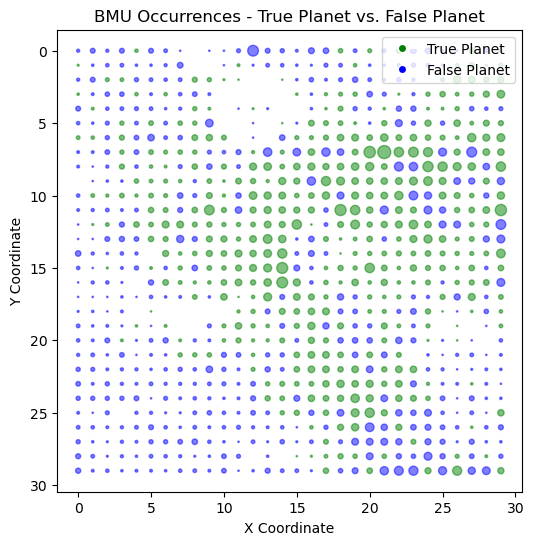

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
View.plot_bmu_occurrences_with_planet_noplanet(ax=ax, coord_label=coord_label)
plt.show()

In [19]:
map = som.collecting_labels(X_train, y_train)
label_map = som.construct_label_map(X_train, y_train)
label_map_kw = som.construct_label_map_weighed(X_train, y_train)
label_map_kcw = som.construct_label_map_occ_weighed(X_train, y_train)

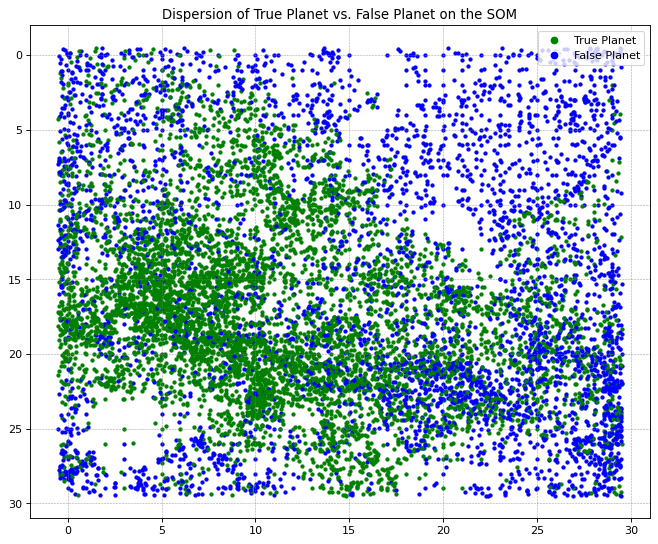

In [23]:
View.plot_dispersion_observation_on_som(X_train=X_train, BMUs=BMUs, BMU_labels=BMU_labels)

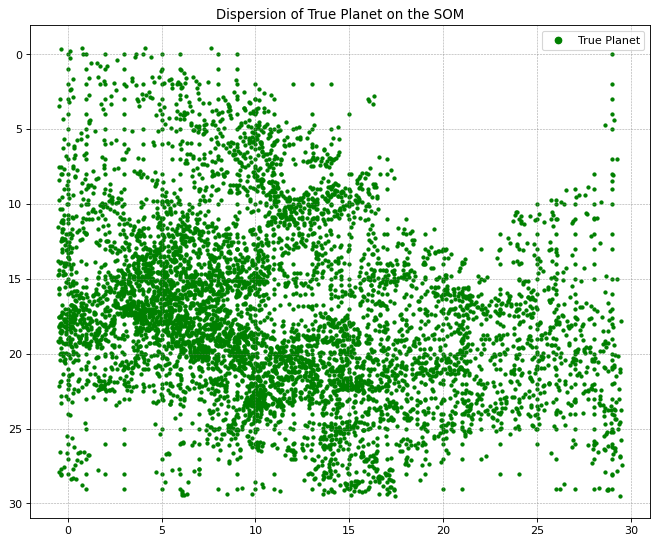

In [24]:
View.plot_class_dispersion_observation_on_som(X_train=X_train, BMUs=BMUs, 
                                              BMU_labels=BMU_labels, classes=1)

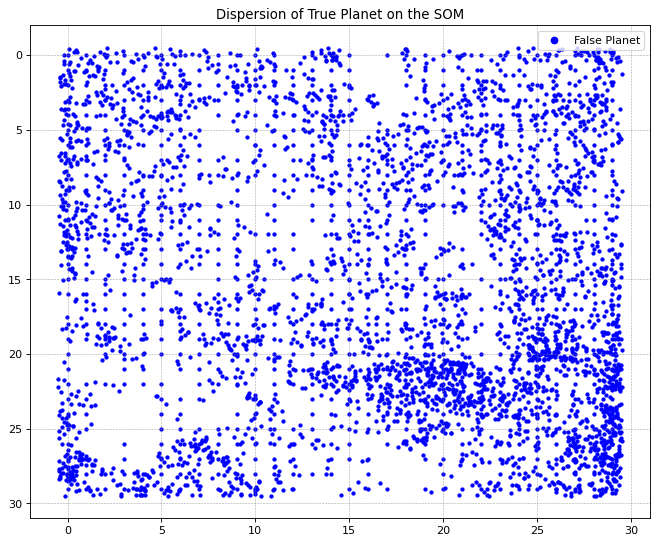

In [25]:
View.plot_class_dispersion_observation_on_som(X_train=X_train, BMUs=BMUs, 
                                              BMU_labels=BMU_labels, classes=0)

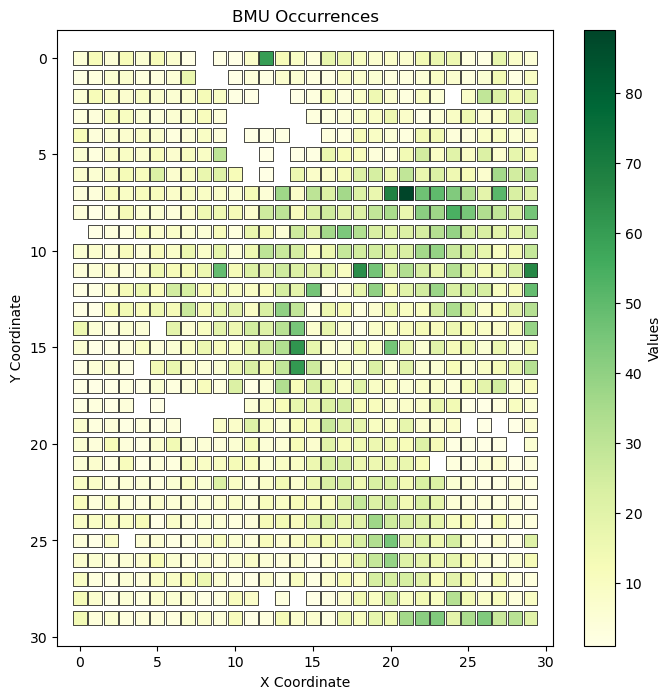

In [20]:
x_coords, y_coords, counts_occ = som.compute_occurrences_plot()

plt.figure(figsize=(8, 8))
sc = plt.scatter(x_coords, y_coords, c=counts_occ, cmap='YlGn', 
                 s=100, marker='s', edgecolors='black', linewidths=0.5)
plt.colorbar(sc, label='Values')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('BMU Occurrences')
plt.gca().invert_yaxis()
plt.show()

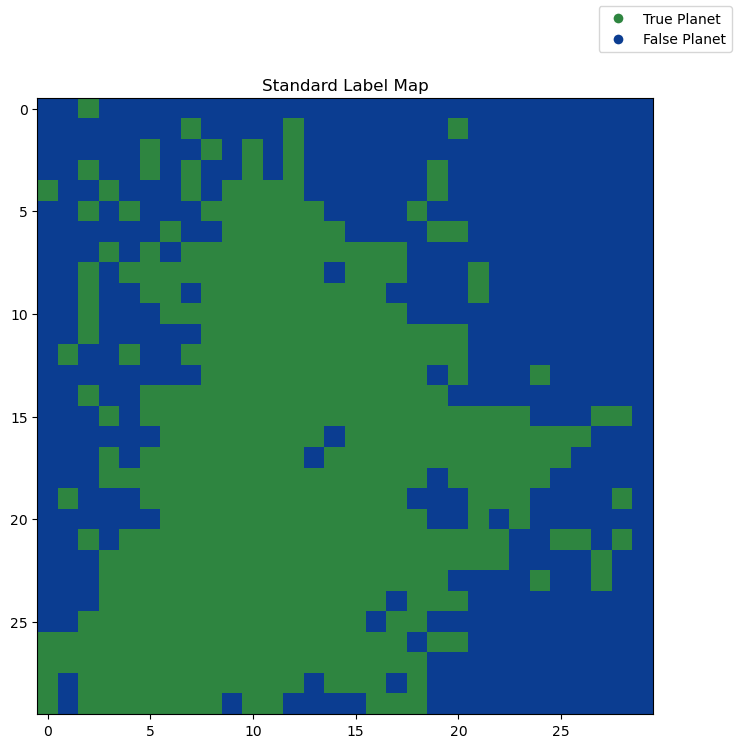

In [21]:
title = ('Standard Label Map')
View.plot_label_map(label_map=label_map, title=title)

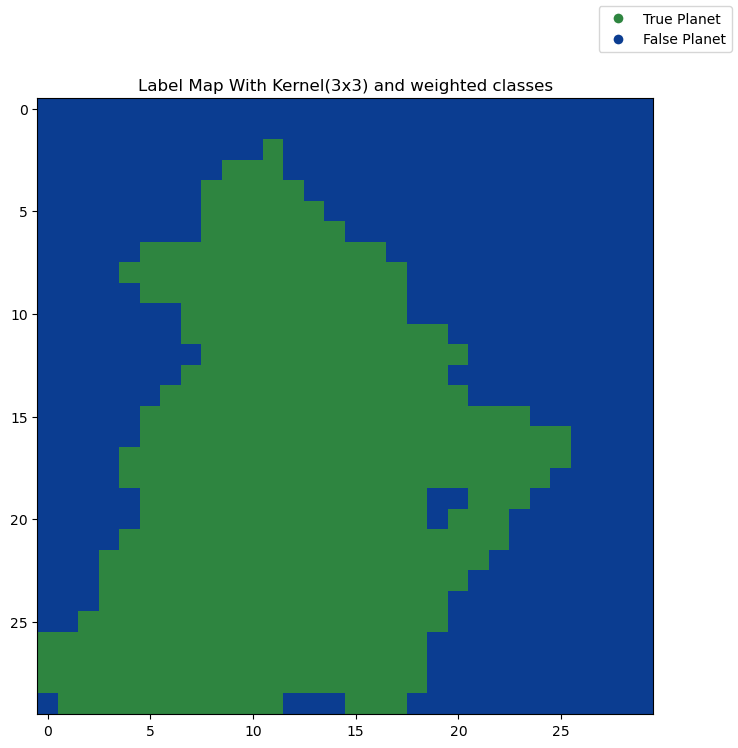

In [22]:
title = ('Label Map With Kernel(3x3) and weighted classes')
View.plot_label_map(label_map=label_map_kw, title=title)

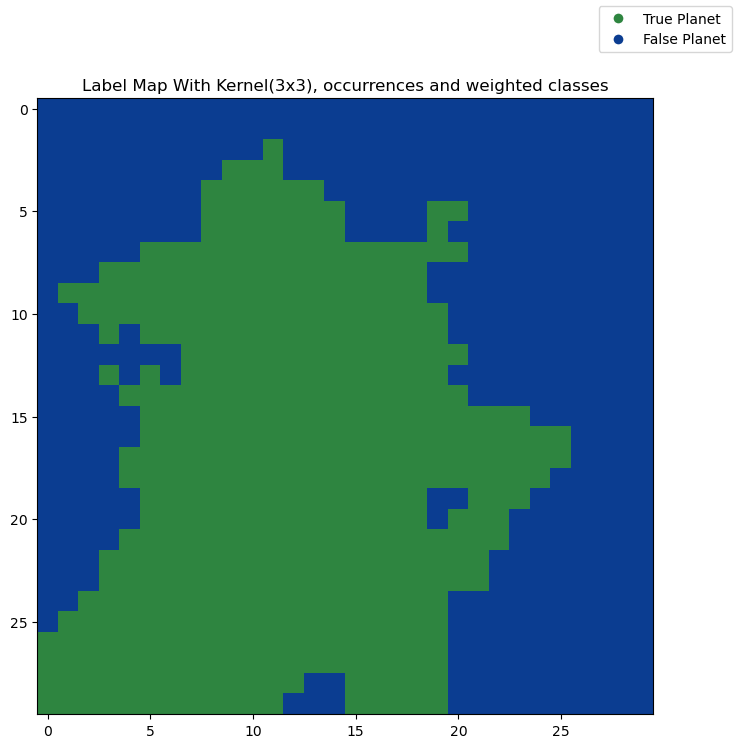

In [23]:
title = ('Label Map With Kernel(3x3), occurrences and weighted classes')
View.plot_label_map(label_map=label_map_kcw, title=title)

Accuracy: 0.756159420289855
F1-score: 0.8056598325151604
Precision: 0.7775919732441472
Recall: 0.8358298382264829
cm:  [[ 692  399]
 [ 274 1395]]


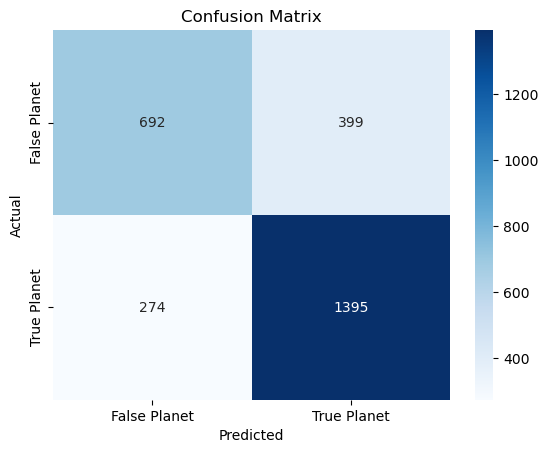

In [24]:
predicted = som.predict(X_train=X_train, y_train=y_train, X_test=X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)

Accuracy: 0.7594202898550725
F1-score: 0.8096330275229358
Precision: 0.7762506871907642
Recall: 0.8460155781905333
cm:  [[ 684  407]
 [ 257 1412]]


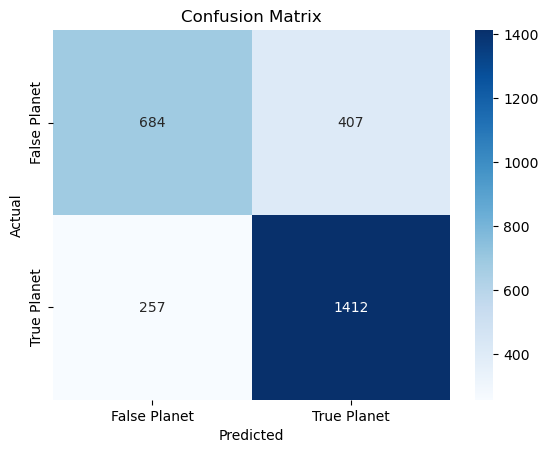

In [25]:
predicted = som.predict_kw(X_train, y_train, X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)

Accuracy: 0.7605072463768116
F1-score: 0.8102210737869653
Precision: 0.7778390297684675
Recall: 0.8454164170161773
cm:  [[ 688  403]
 [ 258 1411]]


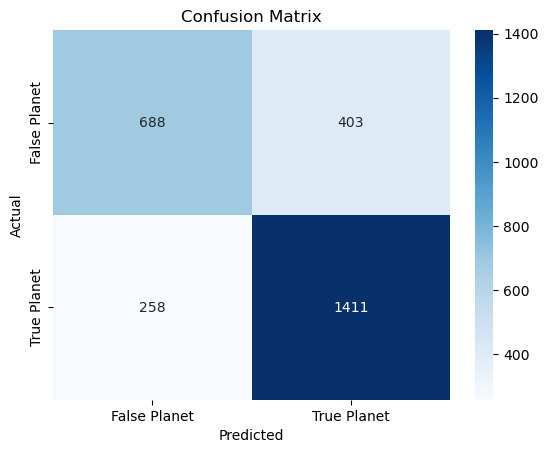

In [26]:
predicted = som.predict_kcw(X_train, y_train, X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)

Accuracy: 0.7619565217391304
F1-score: 0.8104989904816845
Precision: 0.7814238042269188
Recall: 0.8418214499700419
cm:  [[ 698  393]
 [ 264 1405]]


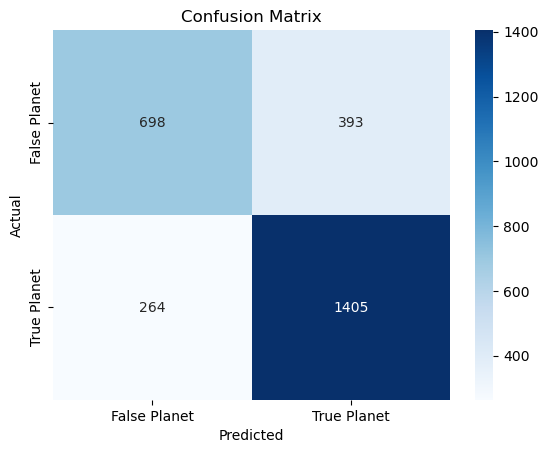

In [27]:
predicted = som.predict_knn(X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)